<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_3_2_QueensGambit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap --quiet

In [ ]:
#@title IMPORTs
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
#@title Hyperparameters
board_size = number_of_queens = 8
seed = 222

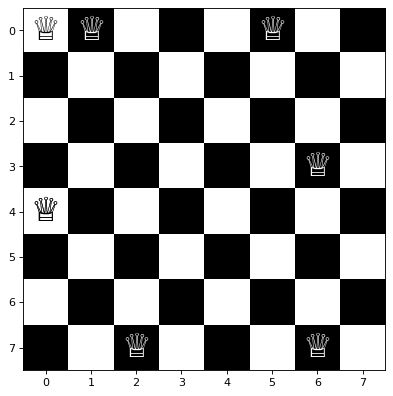

In [ ]:
#@title Setting up the Chessboard
chessboard = np.zeros((board_size,board_size))
chessboard[1::2,0::2] = 1
chessboard[0::2,1::2] = 1

figure(figsize=(6, 6), dpi=80)
plt.imshow(chessboard, cmap='binary')

for _ in range(number_of_queens):
    i, j = np.random.randint(0, board_size, 2)
    plt.text(i, j, '♕', fontsize=30, ha='center', va='center', color='black' if (i - j) % 2 == 0 else 'white')
plt.show()

In [ ]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
#@title Evaluation the Fitness
def evalNQueens(individual):
    """Evaluation function for the n-queens problem.
    The problem is to determine a configuration of n queens
    on a nxn chessboard such that no queen can be taken by
    one another. In this version, each queens is assigned
    to one column, and only one queen can be on each row.
    The evaluation function therefore only counts the number
    of conflicts along the diagonals.
    """
    size = len(individual)
    #Count the number of conflicts with other queens.
    #The conflicts can only be diagonal, count on each diagonal line
    left_diagonal = [0] * (2*size-1)
    right_diagonal = [0] * (2*size-1)
    
    #Sum the number of queens on each diagonal:
    for i in range(size):
        left_diagonal[i+individual[i]] += 1
        right_diagonal[size-1-i+individual[i]] += 1
    
    #Count the number of non-conflicts on each diagonal
    sum_ = 0
    for i in range(2*size-1):
        if left_diagonal[i] > 1:
            sum_ += left_diagonal[i] - 1
        if right_diagonal[i] > 1:
            sum_ += right_diagonal[i] - 1    
    return sum_,

In [ ]:
#@title Filling the Toolbox
toolbox = base.Toolbox()
toolbox.register("permutation", random.sample, range(number_of_queens), number_of_queens)
#Structure initializers
#An individual is a list that represents the position of each queen.
#Only the line is stored, the column is the index of the number in the list.
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.permutation)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalNQueens)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=2.0/number_of_queens)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
#@title Plot Board Function
def plot_board(individual):  
  plt.imshow(chessboard, cmap='binary')
  for i in range(number_of_queens):               
    plt.text(i, individual[i], '♕', fontsize=20, ha='center', va='center', color='black' if (i - individual[i]) % 2 == 0 else 'white')
  plt.show()

In [ ]:
#@title EA Simple Function for Evolution
def eaSimple(population, toolbox, cxpb, mutpb, ngen, max, stats=None, halloffame=None, ):  
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)    
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit            
            if fit[0] >= max:
              print("Solved")
              done = True

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)            
            plot_board(halloffame[0])            

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)     

gen	nevals	Avg 	Std    	Min	Max
0  	100   	4.15	1.49248	0  	8  


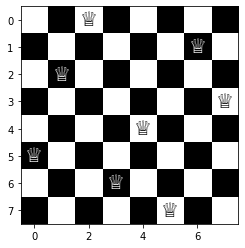

1  	52    	3.15	1.30671	0  	6  


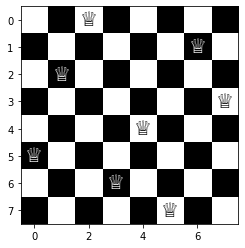

2  	70    	3.25	1.25996	0  	7  


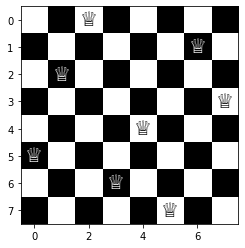

3  	50    	2.81	1.47442	0  	7  


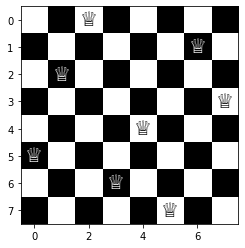

4  	60    	2.45	1.48577	0  	6  


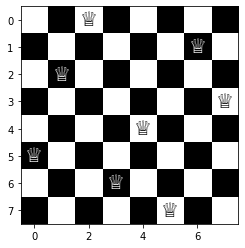

5  	55    	2.29	1.57667	0  	7  


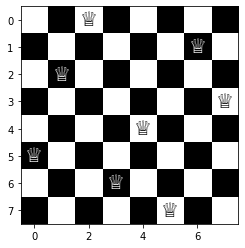

6  	55    	1.88	1.72789	0  	6  


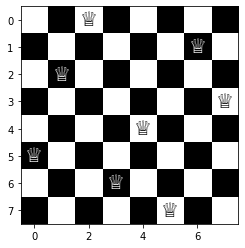

7  	55    	1.4 	1.61245	0  	6  


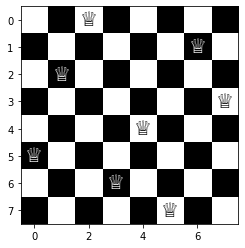

8  	58    	0.94	1.64207	0  	6  


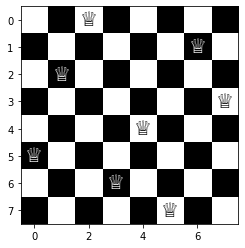

9  	65    	0.72	1.37171	0  	6  


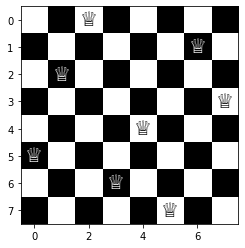

10 	53    	0.7 	1.52643	0  	7  


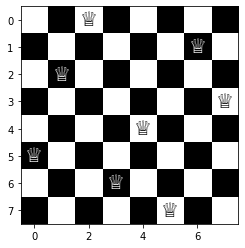

11 	58    	0.56	1.4854 	0  	6  


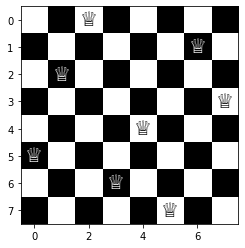

12 	56    	0.44	1.08922	0  	5  


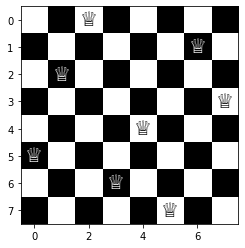

13 	61    	0.72	1.44969	0  	6  


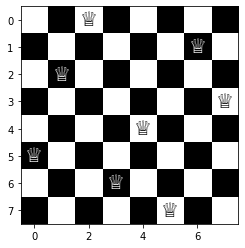

14 	60    	0.58	1.29754	0  	5  


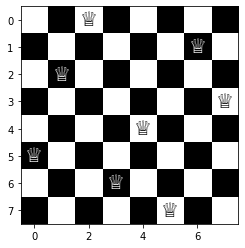

15 	57    	0.72	1.38622	0  	4  


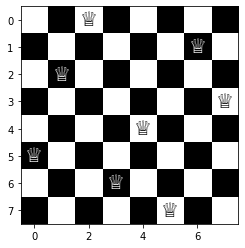

16 	55    	0.33	0.95974	0  	5  


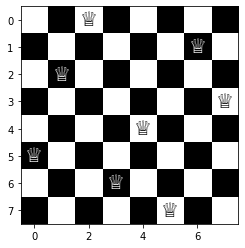

17 	61    	0.5 	1.23693	0  	5  


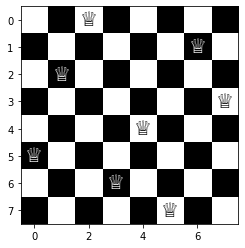

18 	59    	0.55	1.34443	0  	5  


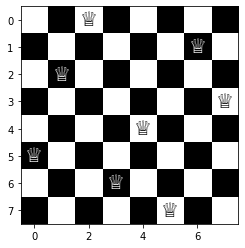

19 	55    	0.51	1.24495	0  	5  


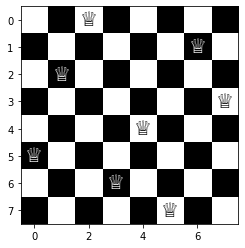

20 	61    	0.72	1.54971	0  	7  


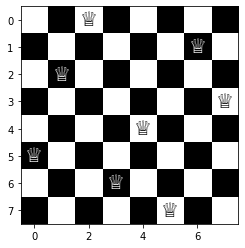

21 	70    	0.75	1.47224	0  	5  


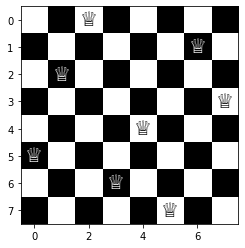

22 	86    	0.74	1.59762	0  	7  


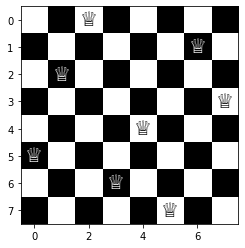

23 	44    	0.58	1.37244	0  	6  


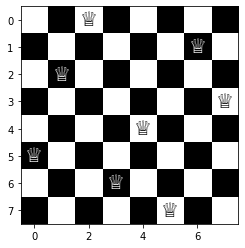

24 	66    	0.58	1.20979	0  	5  


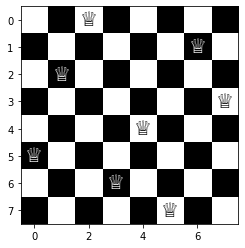

25 	56    	0.48	1.22866	0  	6  


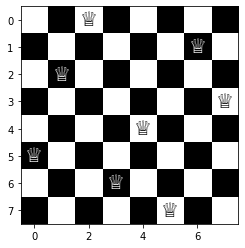

26 	71    	0.63	1.55342	0  	6  


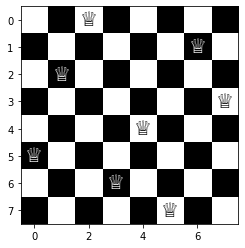

27 	63    	0.6 	1.34907	0  	5  


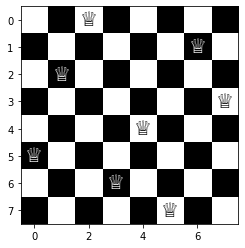

28 	55    	0.54	1.29167	0  	6  


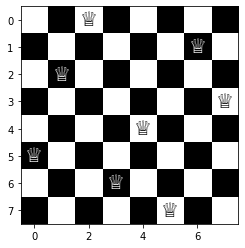

29 	57    	0.66	1.49144	0  	6  


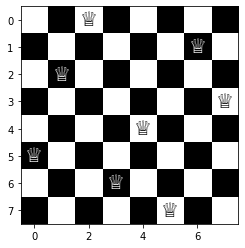

30 	64    	0.41	1.17554	0  	6  


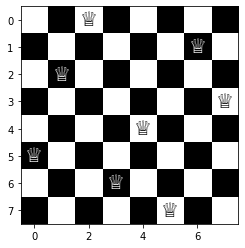

31 	49    	0.52	1.21227	0  	5  


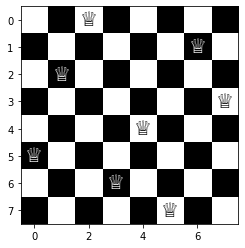

32 	63    	0.86	1.58127	0  	6  


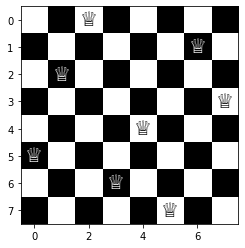

33 	58    	0.74	1.52722	0  	5  


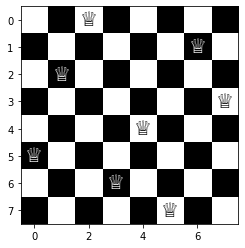

34 	59    	0.47	1.05314	0  	4  


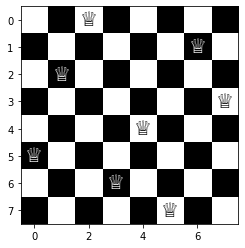

35 	65    	0.41	1.04971	0  	5  


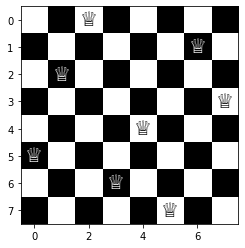

36 	52    	0.7 	1.37477	0  	5  


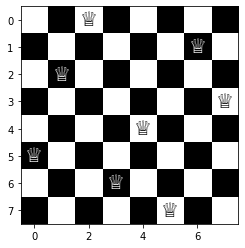

37 	65    	0.57	1.32857	0  	5  


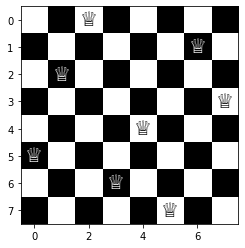

38 	59    	0.69	1.54722	0  	6  


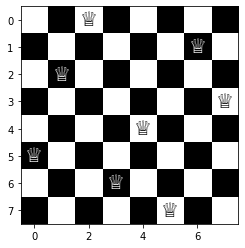

39 	64    	0.73	1.5547 	0  	6  


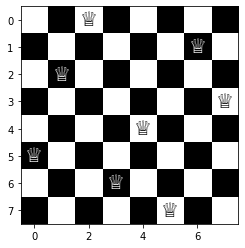

40 	64    	0.72	1.48378	0  	7  


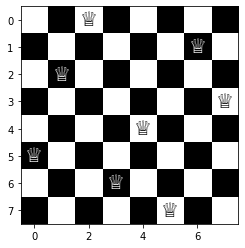

41 	66    	0.44	1.09836	0  	5  


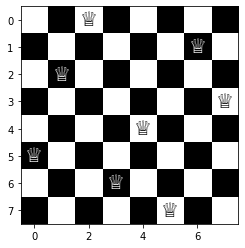

42 	61    	0.47	1.17009	0  	5  


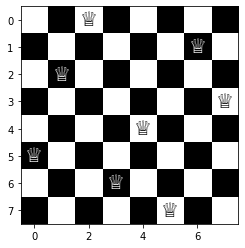

43 	61    	0.78	1.52039	0  	5  


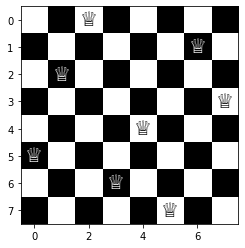

44 	53    	0.73	1.50901	0  	5  


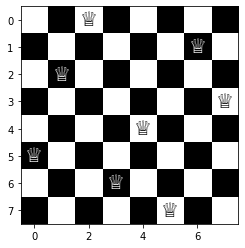

45 	62    	0.57	1.32102	0  	5  


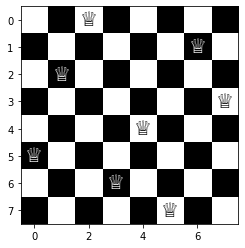

46 	53    	0.69	1.56649	0  	6  


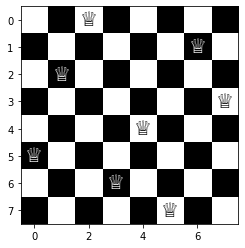

47 	58    	0.51	1.24495	0  	5  


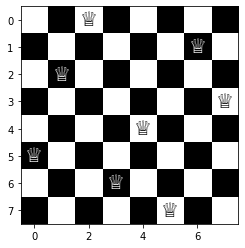

48 	56    	0.5 	1.31529	0  	7  


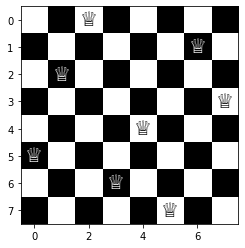

49 	64    	0.51	1.29996	0  	5  


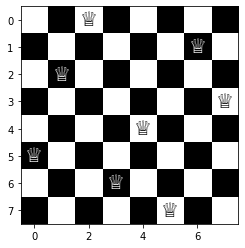

50 	49    	0.39	1.08531	0  	5  


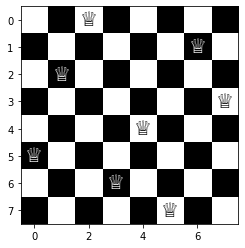

51 	63    	0.6 	1.25698	0  	6  


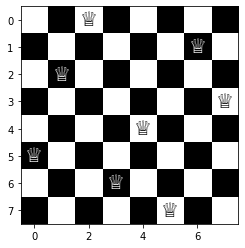

52 	55    	0.79	1.50529	0  	6  


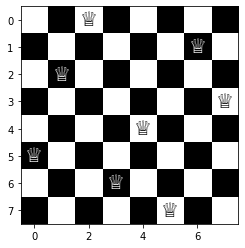

53 	50    	0.47	1.06259	0  	4  


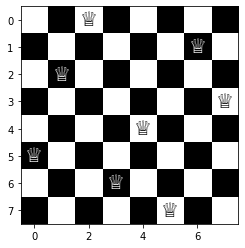

54 	59    	0.46	1.26823	0  	6  


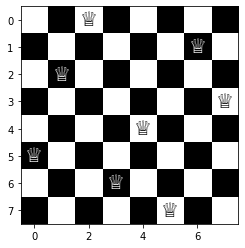

55 	55    	0.89	1.73721	0  	7  


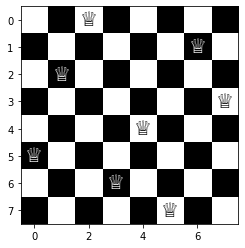

56 	60    	0.51	1.21239	0  	6  


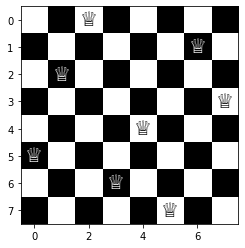

57 	52    	0.64	1.40371	0  	5  


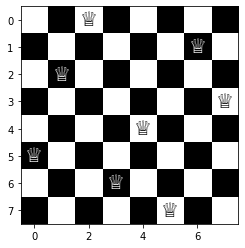

58 	54    	0.79	1.57667	0  	6  


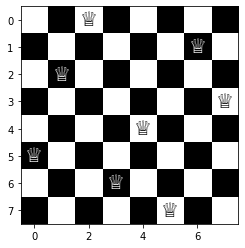

59 	67    	0.57	1.36569	0  	5  


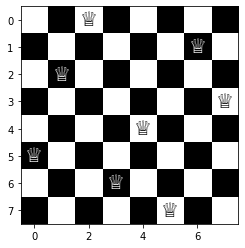

60 	51    	0.49	1.26882	0  	5  


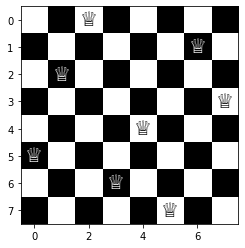

61 	66    	0.64	1.45272	0  	6  


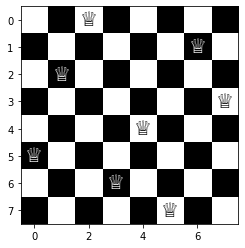

62 	66    	0.47	1.17009	0  	5  


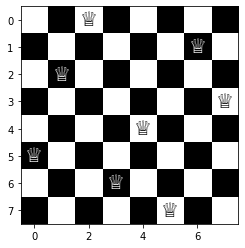

63 	59    	0.52	1.25284	0  	5  


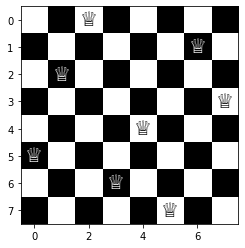

64 	56    	0.57	1.25901	0  	5  


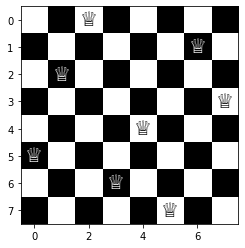

65 	74    	1.07	1.78468	0  	6  


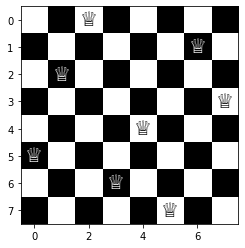

66 	56    	0.52	1.31514	0  	6  
Solved


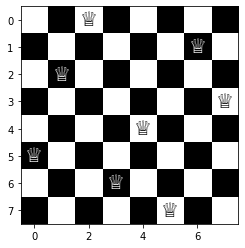

67 	57    	0.8 	1.74929	0  	9  


In [ ]:
#@title Evolving the Population
random.seed(seed)

pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", np.mean)
stats.register("Std", np.std)
stats.register("Min", np.min)
stats.register("Max", np.max)

eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, max = number_of_queens,
         stats=stats ,halloffame=hof)